<a href="https://colab.research.google.com/github/sarathpanat/CNN-dog-breed-prediction/blob/master/dog_breed_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
from glob import glob

human_files = np.array(glob("/content/drive/My Drive/project-dog-classification/project-dog-classification/lfw/*/*"))
dog_files = np.array(glob("/content/drive/My Drive/project-dog-classification/project-dog-classification/dogImages/*/*/*"))

print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 10901 total human images.
There are 8351 total dog images.


Number of faces detected: 1


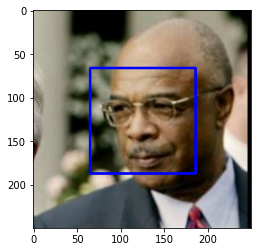

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/project-dog-classification/project-dog-classification/haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [6]:
from tqdm import tqdm

In [7]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_preds = []
dog_preds = []
for i in tqdm(range(100), desc='Image number'):
    human_preds.append(face_detector(human_files_short[i]))
    dog_preds.append(face_detector(dog_files_short[i]))

Image number: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


In [8]:
print(f'Face Detection Accuracy on Human Images: {np.sum(human_preds)/ len(human_preds) * 100}')
print(f'Face Detection Accuracy on Dog Images: {np.sum(dog_preds)/ len(dog_preds) * 100}')

Face Detection Accuracy on Human Images: 99.0
Face Detection Accuracy on Dog Images: 18.0


In [9]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available otherwise use cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# move model to GPU if CUDA is available or to cpu
VGG16 = VGG16.to(device)
print(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



cuda:0


In [10]:
from PIL import Image
import torchvision.transforms as transforms

In [11]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    preprocess = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    img = Image.open(img_path)
    img = preprocess(img)
    img.unsqueeze_(0)
    img = img.to(device)
    
    VGG16.eval()
    with torch.no_grad():
        prediction = VGG16(img).cpu().numpy().argmax()

    return prediction # predicted class index

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    return  151 <= VGG16_predict(img_path) <= 268 # true/false

In [13]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_preds = []
dog_preds = []
for i in tqdm(range(100), desc='Image number'):
    human_preds.append(dog_detector(human_files_short[i]))
    dog_preds.append(dog_detector(dog_files_short[i]))

Image number: 100%|██████████| 100/100 [00:03<00:00, 30.69it/s]


In [14]:
print(f'Dog Detection Accuracy (VGG16) on Human Images: {np.sum(human_preds)/ len(human_preds) * 100}')
print(f'Dog Detection Accuracy (VGG16) on Dog Images: {np.sum(dog_preds)/ len(dog_preds) * 100}')

Dog Detection Accuracy (VGG16) on Human Images: 0.0
Dog Detection Accuracy (VGG16) on Dog Images: 94.0


In [15]:
import os
from torchvision import datasets

In [16]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/project-dog-classification/project-dog-classification/dogImages/'

images_data = {p: datasets.ImageFolder(os.path.join(data_dir, p), 
                                       data_transforms[p]) 
               for p in ['train', 'valid', 'test']}

dataloaders = {p: torch.utils.data.DataLoader(images_data[p], batch_size=64, 
                                              shuffle=True, num_workers=4)
               for p in ['train', 'valid', 'test']}

In [22]:
import torch.nn as nn
import torch.nn.functional as F

In [23]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(28*28*64, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 133)
        )
    
    def forward(self, x):
        ## Define forward behavior
        out = self.layer1(x)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available else CPU
model_scratch.to(device)

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=50176, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=133, bias=True)
  )
)

In [24]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
# optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

In [25]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES=True

In [26]:
def train(n_epochs, loaders, model, optimizer, criterion, device, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU or CPU
            data, target = data.to(device), target.to(device)
            
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
            
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU or CPU
            data, target = data.to(device), target.to(device)
            
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Saving model..')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
            
    # return trained model
    return model

In [27]:
# train the model
model_scratch = train(30, dataloaders, model_scratch, optimizer_scratch, 
                      criterion_scratch, device, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.895463 	Validation Loss: 4.875180
Saving model..
Epoch: 2 	Training Loss: 4.837059 	Validation Loss: 4.707255
Saving model..
Epoch: 3 	Training Loss: 4.724236 	Validation Loss: 4.580758
Saving model..
Epoch: 4 	Training Loss: 4.674062 	Validation Loss: 4.583030
Epoch: 5 	Training Loss: 4.618902 	Validation Loss: 4.510083
Saving model..
Epoch: 6 	Training Loss: 4.535386 	Validation Loss: 4.428856
Saving model..
Epoch: 7 	Training Loss: 4.459739 	Validation Loss: 4.329690
Saving model..
Epoch: 8 	Training Loss: 4.409809 	Validation Loss: 4.292198
Saving model..
Epoch: 9 	Training Loss: 4.352322 	Validation Loss: 4.217736
Saving model..
Epoch: 10 	Training Loss: 4.286748 	Validation Loss: 4.106017
Saving model..
Epoch: 11 	Training Loss: 4.230746 	Validation Loss: 4.088957
Saving model..
Epoch: 12 	Training Loss: 4.171154 	Validation Loss: 3.967229
Saving model..
Epoch: 13 	Training Loss: 4.103298 	Validation Loss: 3.883156
Saving model..
Epoch: 14 	Training Los

In [28]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

<All keys matched successfully>

In [29]:
def test(loaders, model, criterion, device):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU or CPU
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [30]:
# call test function    
test(dataloaders, model_scratch, criterion_scratch, device)

Test Loss: 3.350355


Test Accuracy: 18% (154/836)


In [31]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.vgg16(pretrained=True)
    
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [32]:
for param in model_transfer.features.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier[6].in_features

dog_layer = nn.Linear(n_inputs, len(images_data['train'].classes))
model_transfer.classifier[6] = dog_layer

model_transfer.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [33]:
import torch.optim as optim
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.001)

In [34]:
# train the model
model_transfer = train(30, dataloaders, model_transfer, optimizer_transfer, criterion_transfer, device, 'model_transfer.pt')

Epoch: 1 	Training Loss: 3.413226 	Validation Loss: 1.472918
Saving model..
Epoch: 2 	Training Loss: 2.692734 	Validation Loss: 1.237752
Saving model..
Epoch: 3 	Training Loss: 2.703079 	Validation Loss: 1.125729
Saving model..
Epoch: 4 	Training Loss: 2.668167 	Validation Loss: 1.165201
Epoch: 5 	Training Loss: 2.580304 	Validation Loss: 1.274055
Epoch: 6 	Training Loss: 2.574372 	Validation Loss: 1.104301
Saving model..
Epoch: 7 	Training Loss: 2.519545 	Validation Loss: 0.992618
Saving model..
Epoch: 8 	Training Loss: 2.511196 	Validation Loss: 0.962188
Saving model..
Epoch: 9 	Training Loss: 2.435781 	Validation Loss: 1.042766
Epoch: 10 	Training Loss: 2.472638 	Validation Loss: 1.049798
Epoch: 11 	Training Loss: 2.450111 	Validation Loss: 1.036877
Epoch: 12 	Training Loss: 2.549872 	Validation Loss: 0.921111
Saving model..
Epoch: 13 	Training Loss: 2.442067 	Validation Loss: 0.922983
Epoch: 14 	Training Loss: 2.418583 	Validation Loss: 0.983558
Epoch: 15 	Training Loss: 2.478246 	

In [36]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

In [37]:
test(dataloaders, model_transfer, criterion_transfer, device)

Test Loss: 1.028751


Test Accuracy: 71% (597/836)


In [38]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in images_data['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path)
    img = data_transforms['test'](img)
    img.unsqueeze_(0)
    img = img.to(device)
    
    model_transfer.eval()
    with torch.no_grad():
        prediction = model_transfer(img).cpu().numpy().argmax()

    return class_names[prediction] # predicted dog breed

In [39]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither

    if dog_detector(img_path):
        case = 1
    elif face_detector(img_path):
        case = 2
    else:
        print('Neither Dog nor Human was detected')
        case = 0
        
    if case == 1 or case == 2:        
        breed = predict_breed_transfer(img_path)
        
        up_text = 'Hello Dog!!' if case == 1 else 'Hello Human!!'
        down_text = f'Your predicted breed is...\n{breed}' if case == 1 else f'You look like a...\n{breed}'
        
        img = Image.open(img_path)
        plt.imshow(img)
        plt.text(2, -5, up_text)
        plt.text(10, img.size[1]+50, down_text)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.show()

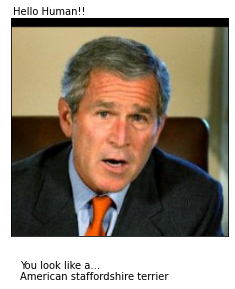

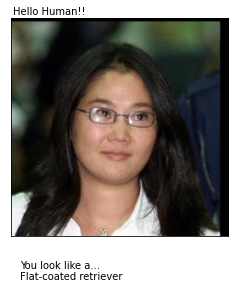

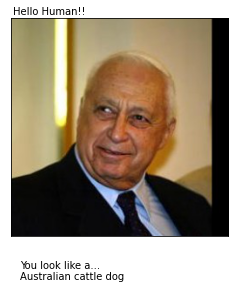

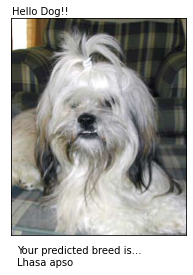

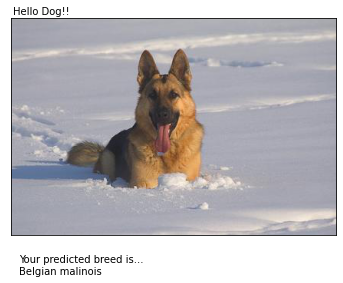

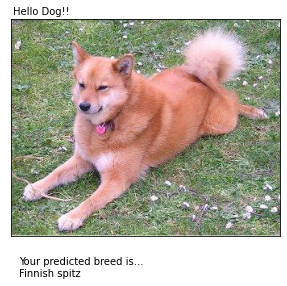

In [40]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((np.random.choice(human_files, 3), np.random.choice(dog_files, 3))):
    run_app(file)